#MIT 6.036 Spring 2019: Homework 8#

This colab notebook provides code and a framework for [homework 8](https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week8/week8_homework/).  You can work out your solutions here, then submit your results back on the homework page when ready.

## <section>**Setup**</section>

First, download the code distribution for this homework that contains test cases and helper functions.

Run the next code block to download and import the code for this lab.


# 2) Implementing Mini-batch Gradient Descent and Batch Normalization (OPTIONAL)

** Note: You can click the arrow on the left of this text block to collapse/expand this optional section and all its code blocks **

Last week we implemented a framework for building neural networks from scratch. We trained our models using *stochastic* gradient descent. In this problem, we explore how we can implement batch normalization as a module `BatchNorm` in our framework. It is the same module which you analyzed in problem 1.

Key to the concept of batch normalization is the doing gradient descent on batches of data. So we instead of using last week's stochastic gradient descent, we will first implement the *mini-batch* gradient descent method `mini_gd`, which is a hybrid between *stochastic* gradient descent and *batch* gradient descent. The lecture notes on <a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week7/neural_networks_2/1?activate_block_id=block-v1%3AMITx%2B6.036%2B2019_Spring%2Btype%40vertical%2Bblock%40neural_networks_2_optimizing_neural_network_parameters_vert"> optimizing neural network parameters</a> are helpful for this part.

In *mini-batch* gradient descent, for a mini-batch of size $K$, we select $K$ distinct data points uniformly at random from the data set and update the network weights based only on their contributions to the gradient:
$$W := W - \eta\sum_{i=1}^K \nabla_W \mathcal{L}(h(x^{(i)}; W), y^{(i)})\;\;.$$

Our *mini-batch* method `mini_gd` will be implemented within the `Sequential` python class (see homework 7 problem 2) and will take the following as inputs:

* `X`: a standard data array (d by n)
* `y`: a standard labels row vector (1 by n)
* `iters`: the number of updates to perform on weights $W$
* `lrate`: the learning rate used
* `K`: the mini-batch size to be used

One call of `mini_gd` should call `Sequential.backward` for back-propagation and `Sequential.step` for updating the weights, for a total of `iters` times, using `lrate` as the learning rate. As in our implementation of `sgd` from homework 7, we compute the predicted output for a mini-batch of data with the `Sequential.forward` method. We compute the loss between our predictions and the true labels using the assigned `Sequential.loss` method. (Note that in homework 7, `Sequential.step` was called `Sequential.sgd_step`. While the functionality of the step function is the same, it has been renamed for convenience. The same is true for the `module.step` function of each module we implemented, where applicable.)

For picking $K$ unique data points at random from our large data-set for each mini-batch, we will implement the following strategy: we will first shuffle our data points `X` (and associated labels `y`). Then, we get <math>\frac{n}{k}</math> (rounded down to the nearest integer) different mini-batches by grouping each $K$ consecutive points from this shuffled array. If we end up iterating over all the points but need more mini-batches, we will repeat the shuffling and the batching process.

<b>2A)</b>You need to fill in the missing code below. We have implemented the shuffling of indices and have provided you with the outer and inner loops.

** This OPTIONAL problem has you extend your homework 7 implementation for building neural networks. **
### PLEASE COPY IN YOUR CODE FROM HOMEWORK 7 TO COMPLEMENT THE CLASSES GIVEN HERE

Recall that your implementation from homework 7 included the following classes:
    
  * Module
  * Linear
  * Tanh
  * ReLU
  * SoftMax
  * NLL
  * Sequential

In [1]:
import math as m

class Sequential:
    def __init__(self, modules, loss):
        self.modules = modules
        self.loss = loss

    def mini_gd(self, X, Y, iters, lrate, notif_each=None, K=10):
        D, N = X.shape

        np.random.seed(0)
        num_updates = 0
        indices = np.arange(N)
        while num_updates < iters:

            np.random.shuffle(indices)
            X = None  # Your code
            Y = None  # Your code

            for j in range(m.floor(N/K)):
                if num_updates >= iters: break

                # Implement the main part of mini_gd here
                # Your code

                num_updates += 1

    def forward(self, Xt):
        for m in self.modules: Xt = m.forward(Xt)
        return Xt

    def backward(self, delta):
        for m in self.modules[::-1]: delta = m.backward(delta)

    def step(self, lrate):
        for m in self.modules: m.step(lrate)

<b>2B)</b> We are now ready to implement batch normalization into our neural network framework! Our module `BatchNorm` will sit between consecutive layers of neurons, such as the $l^{th}$ and $(l+1)^{th}$ layers, acting as a "corrector" which allows $W^l$ to change freely, producing outputs $z^l$, but then the module corrects the covariate shift induced in the signals before they reach the $(l+1)^{th}$ layer, converting $z^l$ to $\widehat{Z}^l$.

The following is a summmary what is described in the <a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week7/neural_networks_2/2">lecture notes</a>, and it should guide your implementation of the module.

Any normalization between the $l^{th}$ and $(l+1)^{th}$ layers is done *separately* for each of the $n^l$ input connections leading to the $(l+1)^{th}$ layer. We handle a mini-batch of data of size $K$, and $Z^l$ is $n^l \times K$, and the output $\widehat{Z}^l$is of the same shape.

We first compute $n^l$ *batchwise* means and
standard deviations.  Let $\mu^l$ be the $n^l \times 1$ vector (`self.mus`) where
$$\mu^l_i = \frac{1}{K} \sum_{j = 1}^K Z^l_{ij}\;\;,$$
and let $\sigma^l$ be the $n^l \times 1$ vector (`self.vars`) where
$$\sigma^l_i = \sqrt{\frac{1}{K} \sum_{j = 1}^K (Z^l_{ij} - \mu_i)^2}\;\;.$$

The normalized data `self.norm` is the matrix $\overline{Z}$, where
$$\overline{Z}^l_{ij} = \frac{Z^l_{ij} - \mu^l_i}{\sigma^l_i + \epsilon}\;\;,$$
and where $\epsilon$ is a very small constant to guard against division by
zero.

We define weights $G^l$ (`self.G`) and $B^l$ (`self.B`), each being an $n^l \times 1$ vector, which we use to to shift and scale the outputs:
$$\widehat{Z}^l_{ij} = G^l_i \overline{Z}^l_{ij} + B^l_i\;\;.$$

The outputs are finally ready to be passed to the $(l+1)^{th}$ layer.

A slight warning (that we will not worry about here) about `BatchNorm` is that during the *test* phase, if the test mini-batch size is too small (imagine we are deploying a neural network that deals with live video frames), then the lack of samples would cause the freshly-calculated $\mu^l$ and $\sigma^l$ to be far off from their true values that the module's parameters $G^l$ and $B^l$ were trained to be compatible with. To fix that, people usually compute a running average of $\mu^l$ and $\sigma^l$ during training, to be used at test time. We will assume our test mini-batches are large enough.

In this problem we only implement the `BatchNorm.forward` and `BatchNorm.step` methods. We provide you with the implementation for `BatchNorm.backward` and the lecture notes contain the details of the derivations. You will need to fill in the missing code below.

In [2]:
class BatchNorm(Module):
    def __init__(self, m):
        np.random.seed(0)
        self.eps = 1e-20
        self.m = m  # number of input channels

        # Init learned shifts and scaling factors
        self.B = np.zeros([self.m, 1])
        self.G = np.random.normal(0, 1.0 * self.m ** (-.5), [self.m, 1])

    # Works on m x b matrices of m input channels and b different inputs
    def forward(self, A):# A is m x K: m input channels and mini-batch size K
        # Store last inputs and K for next backward() call
        self.A = A
        self.K = A.shape[1]

        self.mus = None  # Your Code
        self.vars = None  # Your Code

        # Normalize inputs using their mean and standard deviation
        self.norm = None  # Your Code

        # Return scaled and shifted versions of self.norm
        return None  # Your Code

    def backward(self, dLdZ):
        # Re-usable constants
        std_inv = 1/np.sqrt(self.vars+self.eps)
        A_min_mu = self.A-self.mus

        dLdnorm = dLdZ * self.G
        dLdVar = np.sum(dLdnorm * A_min_mu * -0.5 * std_inv**3, axis=1, keepdims=True)
        dLdMu = np.sum(dLdnorm*(-std_inv), axis=1, keepdims=True) + dLdVar * (-2/self.K) * np.sum(A_min_mu, axis=1, keepdims=True)
        dLdX = (dLdnorm * std_inv) + (dLdVar * (2/self.K) * A_min_mu) + (dLdMu/self.K)

        self.dLdB = np.sum(dLdZ, axis=1, keepdims=True)
        self.dLdG = np.sum(dLdZ * self.norm, axis=1, keepdims=True)
        return dLdX

    def step(self, lrate):
        self.B = None  # Your Code
        self.G = None  # Your Code
        return

NameError: name 'Module' is not defined

# 3) 2D Datasets

For the 2D datasets, we have provided the following function:


```
run_keras_2d(data_name, layers, epochs, split=0.25, display=True, trials=5)
```


where:

data_name is a string, such as '1', '2', etc.
layers is a list of Keras layer definitions for a Sequential model, e.g.
```
[Dense(input_dim=2, units=10, activation='relu'), Dense(units=2, activation='softmax')]
```

epochs is an integer indicating how many times to go through the data in training
split is a fraction of the training data to use for validation if a validation set is not defined
display whether to display result plots
verbose whether to print loss and accuracy (percent correctly labeled) each epoch
trials is an integer indicating how many times to perform the training and testing
2D Data
The two-class datasets have data_names: '1','2','3','4'. Target accuracies (percent correct) on the validation set are (99%, 90.5%, 96%, 94%).

In this problem, try the following 5 architectures, specified by the number of units in the hidden layers:

1: (0), 2: (10), 3: (100), 4: (10, 10), 5: (100, 100))
You may find the archs function in the code file to be helpful here.
Some of these questions ask for the "simplest" architecture; the list above is ordered starting with the simplest.

In [3]:
from code_for_hw8_keras import *
import keras
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Conv1D, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
import keras.utils as np_utils
from keras.callbacks import Callback
from keras.datasets import mnist
from keras import backend as K
from keras.initializers import VarianceScaling
from matplotlib import pyplot as plt

In [10]:
layer1 = keras.layers.Dense(units=3, activation='relu', use_bias=False)

for d in "1234":
    print("<<<<<", "data set:", d, ">>>>>")
    for i in range(5):
        print("===== arc: ", i+1, "=====")
        X_train, y, model = run_keras_2d(d, archs(2)[i], 10, split=0.25, display=False, verbose=False, trials=5)


<<<<< data set: 1 >>>>>
===== arc:  1 =====
Keras FC: dataset= 1
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {0.0, 1.0}


c:\Users\Eric2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Loss on validation set:0.0562613382935524 Accuracy on validation set: 1.0

Loss on validation set:0.0030210711993277073 Accuracy on validation set: 1.0

Loss on validation set:0.0007082797819748521 Accuracy on validation set: 1.0

Loss on validation set:0.00025833616382442415 Accuracy on validation set: 1.0

Loss on validation set:0.00010834924614755437 Accuracy on validation set: 1.0

Avg. validation accuracy:1.0
===== arc:  2 =====
Keras FC: dataset= 1
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {0.0, 1.0}

Loss on validation set:0.0026844285894185305 Accuracy on validation set: 1.0

Loss on validation set:3.751875919988379e-05 Accuracy on validation set: 1.0

Loss on validation set:1.3058630656814785e-06 Accuracy on validation set: 1.0

Loss on validation set:5.0067729517877524e-08 Accuracy on validation set: 1.0

Loss on validation set:2.38418529363571e-09 Accuracy on validation set: 1.0

Avg.

Keras FC: dataset= 3
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {0.0, 1.0}
Epoch 1/100


c:\Users\Eric2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.9420 - loss: 0.2285 - val_acc: 0.9550 - val_loss: 0.1428
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9595 - loss: 0.0929 - val_acc: 0.9550 - val_loss: 0.1087
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9789 - loss: 0.0638 - val_acc: 0.9600 - val_loss: 0.1617
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9742 - loss: 0.0818 - val_acc: 0.9650 - val_loss: 0.1136
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9912 - loss: 0.0330 - val_acc: 0.9500 - val_loss: 0.1448
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9660 - loss: 0.0790 - val_acc: 0.9700 - val_loss: 0.1256
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9869 - loss: 0.0389 - val_acc: 0.9700 - val_loss: 0.1280
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9743 - loss: 0.0395 - val_acc: 0.9650 - val_loss: 0.1118
Epoch 9/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 

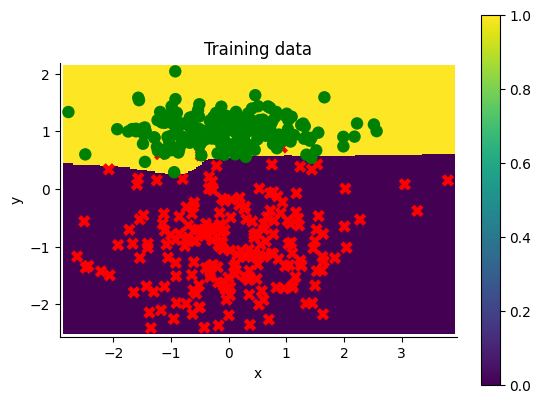

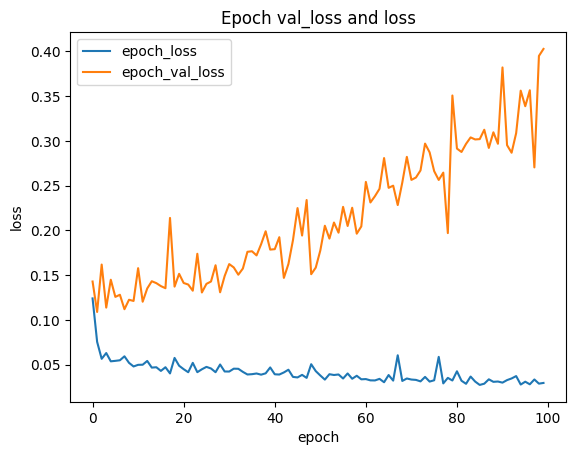

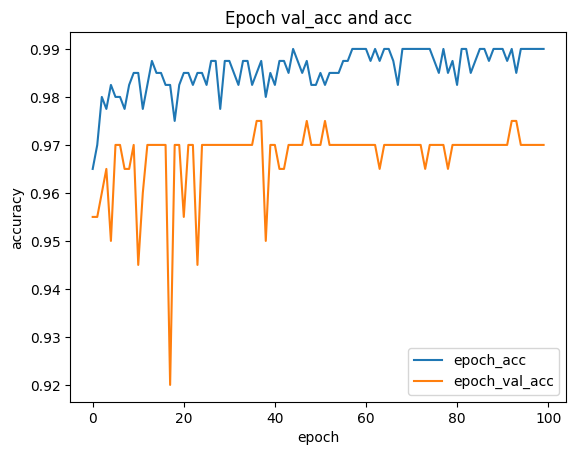


Avg. validation accuracy:0.9700000286102295


In [13]:
layers = [
    Dense(input_dim=2, units=100, activation="relu"),
    Dense(units=100, activation="relu"),
    Dense(units=2, activation="softmax"),
]
X_train, y, model = run_keras_2d(
    "3", layers, 100, True, verbose=True
)

In [15]:
for i in range(5):
    print(f"===== arch {i+1} =====")
    run_keras_2d("3class", archs(3)[i], 10, display=False, verbose=False, trials=5)

===== arch 1 =====
Keras FC: dataset= 3class
Loading X (800, 2) y (800,) classes {0.0, 1.0, 2.0}


c:\Users\Eric2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Loss on validation set:0.4056474566459656 Accuracy on validation set: 0.875

Loss on validation set:0.39290186762809753 Accuracy on validation set: 0.8899999856948853

Loss on validation set:0.39776819944381714 Accuracy on validation set: 0.8899999856948853

Loss on validation set:0.40076497197151184 Accuracy on validation set: 0.8899999856948853

Loss on validation set:0.40313294529914856 Accuracy on validation set: 0.8899999856948853

Avg. validation accuracy:0.8869999885559082
===== arch 2 =====
Keras FC: dataset= 3class
Loading X (800, 2) y (800,) classes {0.0, 1.0, 2.0}

Loss on validation set:0.1731547713279724 Accuracy on validation set: 0.9449999928474426

Loss on validation set:0.15510521829128265 Accuracy on validation set: 0.9549999833106995

Loss on validation set:0.16296985745429993 Accuracy on validation set: 0.9649999737739563

Loss on validation set:0.17269296944141388 Accuracy on validation set: 0.9549999833106995

Loss on validation set:0.1861058473587036 Accuracy on

Keras FC: dataset= 3class
Loading X (800, 2) y (800,) classes {0.0, 1.0, 2.0}
Epoch 1/10


c:\Users\Eric2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.0371 - loss: 1.9987 - val_acc: 0.1650 - val_loss: 1.3702
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.1860 - loss: 1.2879 - val_acc: 0.4100 - val_loss: 0.8774
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6656 - loss: 0.8546 - val_acc: 0.8950 - val_loss: 0.6343
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8959 - loss: 0.6363 - val_acc: 0.9300 - val_loss: 0.5083
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9178 - loss: 0.5132 - val_acc: 0.9300 - val_loss: 0.4375
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9060 - loss: 0.4571 - val_acc: 0.9250 - val_loss: 0.3915
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8852 - loss: 0.4538 - val_acc: 0.9250 - val_loss: 0.3610
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8857 - loss: 0.3974 - val_acc: 0.9250 - val_loss: 0.3401
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9064 -

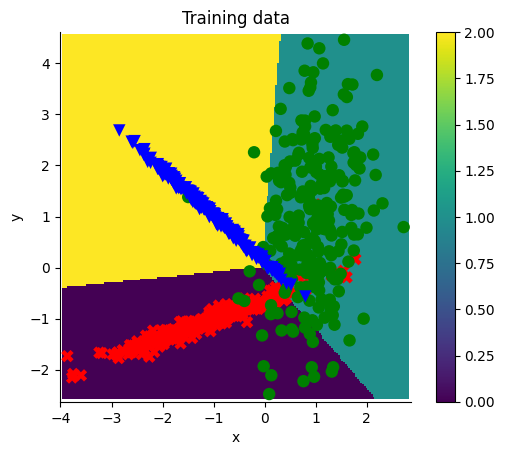

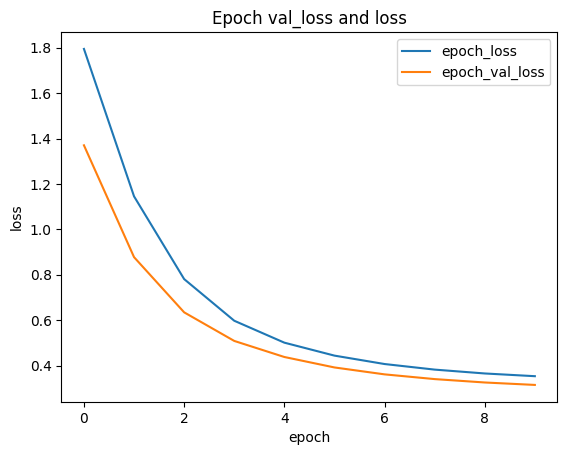

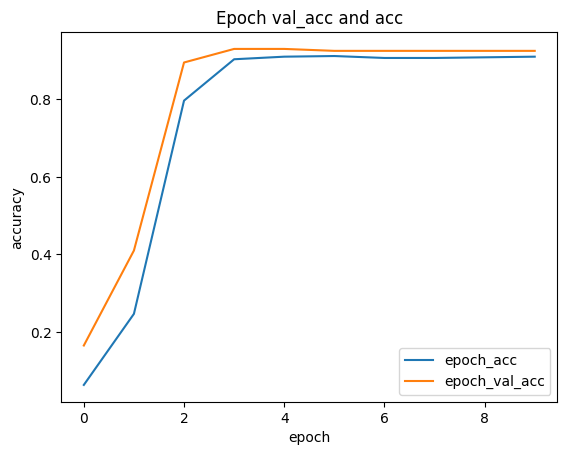


Avg. validation accuracy:0.925000011920929


(array([[ 0.14025757, -0.04507723],
        [-0.42922777, -0.91245326],
        [-1.07472311, -1.15220876],
        ...,
        [ 0.49427279,  2.07863896],
        [ 0.28104154,  1.70306447],
        [-1.94649872,  1.91693874]]),
 array([2., 0., 0., 0., 1., 1., 1., 2., 2., 1., 0., 0., 0., 0., 1., 2., 0.,
        2., 0., 0., 0., 1., 0., 2., 0., 1., 2., 2., 0., 1., 0., 2., 0., 0.,
        1., 2., 0., 0., 0., 0., 1., 2., 1., 2., 2., 1., 2., 2., 2., 1., 0.,
        0., 1., 2., 0., 1., 0., 2., 0., 0., 0., 1., 1., 1., 0., 2., 0., 0.,
        2., 1., 1., 2., 2., 1., 2., 2., 1., 0., 2., 2., 1., 2., 0., 2., 2.,
        1., 2., 2., 1., 2., 0., 1., 0., 2., 0., 0., 1., 2., 1., 2., 2., 1.,
        0., 1., 0., 2., 0., 1., 1., 0., 0., 2., 2., 2., 2., 1., 0., 0., 0.,
        2., 2., 2., 1., 0., 0., 2., 0., 0., 1., 2., 2., 2., 2., 1., 1., 1.,
        0., 2., 2., 1., 1., 1., 0., 0., 2., 0., 0., 2., 2., 1., 2., 0., 2.,
        1., 2., 2., 2., 0., 2., 0., 0., 1., 1., 2., 0., 1., 2., 0., 0., 2.,
        1

In [22]:
np.random.seed(0)
layers=[Dense(input_dim=2, units=3,activation="softmax")]
run_keras_2d("3class", layers, 10)

In [25]:
weights = layers[0].get_weights()
W, W0 = weights
W0 = np.array([W0]).T
points = [[-1,0], [1,0], [0,-11], [0,1], [-1,-1], [-1,1], [1,1], [1,-1]]
x = np.array(points).T
Z = W.T @ x + W0
classes = np.argmax(Z, axis=0).tolist()
print(Z)
print(classes)


[[  0.82528811  -0.90115411  11.03154372  -1.04424907   1.83160417
   -0.18102796  -1.90747018   0.10516195]
 [ -1.37979679   1.53341098 -10.81923942   1.06735678  -2.37034647
   -0.3892471    2.52396066   0.5428613 ]
 [  1.04038319  -1.12968579 -13.10965589   1.14307639  -0.1473445
    2.22811088   0.0580419   -2.31741348]]
[2, 1, 0, 2, 0, 2, 1, 1]


# Weight sharing (OPTIONAL)

** Note: You can click the arrow on the left of this text block to collapse/expand this optional section and all its code blocks **

In the lab we designed a CNN that can count the number of objects in 1 dimensional images, where each black pixel is represented by a value of 0 and each white pixel is represented by a value of 1. Recall that an object is a consecutive sequence of black pixels ($0$'s). For example, the sequence $0100110$ contains three objects.

Here we want to see how hard/easy it is to train such a network from data.  Our network architecture will be as follows:

* The first layer is convolutional and you will implement it using the Keras `Conv1D` function, with a kernel of size 2 and stride of 1 with ReLu activation.

* The second layer is a fully connected `Dense` layer which has a scalar output.

Here is sample usage of the `Conv1D` and`Dense` layers.

`layer1=keras.layers.Conv1D(filters=?, kernel_size=?, strides=?,use_bias=False, activation=?, batch_size=1, input_shape=?, padding='same')`

`Dense(units=?, activation=?, use_bias=False)`

You need to fill in the parameters marked with `?` based on the problem specifications. Note also that in Keras, depending on your implementation, you may be forced to use *three* layers to implement such a network, where one intermediary `Flatten` layer is used to flatten the output of the convolutional layer, before being passed to the dense layer.

Refer to the <a href="https://keras.io/layers/convolutional/">Conv 1D</a>, <a href="https://keras.io/layers/core/">Dense</a> and <a href="https://keras.io/layers/core/#flatten">Flatten</a> descriptions in the Keras documentation to see the available parameter options.

In this exercise, we fix the structure and want to learn the best combination of weights from data. In the homework code, we have provided functions `train_neural_counter` and `get_image_data_1d`. You can use them to generate data and train the above neural network in Keras to answer the following questions. We assume that the images in our data set are randomly generated. The probability of a pixel being white is $0.1$. We work with mean squared error as the loss function for this problem. We have provided template code which you can fill in, to perform the training.

<b>4B)</b> What is (approximately) the expected loss of the network on $1024\times 1$ images if the convolutional layer is an averaging filter and second layer is the sum function (without a bias term)? (Note that you can answer the question theoretically or through coding, depending on your preference.)

In [ ]:
from keras.models import Sequential

In [ ]:
# Code template if you would like to check 4B) through code

imsize = 1024
prob_white = 0.1

num_filters = None  # Your code
kernel_size = None  # Your code
strides = None  # Your code
activation_conv = None  # Your code

(X_train,Y_train,X_val,Y_val,X_test,Y_test) = get_image_data_1d(1000,imsize,prob_white)

layer1=keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, \
       strides=strides, use_bias=False, activation=activation_conv, batch_size=1, input_shape=(imsize,1), padding='same')

activation_dense = None  # Your code
num_units = None  # Your code
layer3=Dense(units=num_units, activation=activation_dense, use_bias=False)

layers=[layer1,Flatten(),layer3]

# This is how we create the model using our layers
model=Sequential()
for layer in layers:
    model.add(layer)

model.compile(loss='mse', optimizer=Adam())

# Set the weights of the layers to desired values
# We give you the lines to use for this part
model.layers[0].set_weights([np.array([1/2,1/2]).reshape(2,1,1)])
model.layers[-1].set_weights([np.ones(imsize).reshape(imsize,1)])

model.evaluate(X_test,Y_test)

<b>4C)</b> Now suppose we add a bias term of $-10$ to the last layer. What is (approximately) the expected quadratic loss? (Note that you can answer the question theoretically or through coding, depending on your preference.)

In [ ]:
# Edit code from 4B) with the bias

<b>4D)</b> Averaging type filters are abundant and form a nearly flat valley of local minima for this problem. It is difficult for the network to find alternative solutions on its own. We need to force our way out of these bad minima and towards a better solution, i.e., an edge detector. To force the first layer to behave as an edge detector, we need to choose a proper **kernel regularizer**. Consider the following functions

$f_1=\sum_i |w_i|$, $f_2=\sum_i |w_i^2|$, $f_3=|\sum_{i} w_i|$. Which one of the choices is likely to guide the network to find an edge detector at the convolution layer?


<a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week8/week8_homework/">Refer to Catsoop.</a>

Implement your choice of regularizers from above in the code (complete the function `filter_reg`). Do not allow any bias in the layers for the rest of the problem. The code generates some random test and training data sets and trains the model on these data. Run a few learning trials (5 or more) for each data set and answer the following questions based on the performance of your model.

**IMPORTANT**: When implementing `filter_reg`, you should use the keras backend operations, imported as "K" in the code. So for example, `K.sum` and `K.abs`, rather than `np.sum` and `np.abs`. This is because the `weights` argument is NOT a numpy object, but rather an internal Keras object!

In [ ]:
# Implement filter_reg

def filter_reg(weights):
    # We scale the output of the filter by lam
    lam=1000
    filter_result = None  # Your code
    return lam * filter_result

<b>4E)</b> For $1024\times 1$ images and training set of size $1000$, is the network **without any regularization** likely to find models that have a mean square error lower than 8 on the test data?

In [ ]:
# Code template if you would like to check 4B) through code

imsize = 1024
prob_white = 0.1

data=get_image_data_1d(1000, imsize, prob_white)
trials=5
for trial in range(trials):

    num_filters = None  # Your code
    kernel_size = None  # Your code
    strides = None  # Your code
    activation_conv = None  # Your code

    layer1=keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, \
    strides=strides, use_bias=False, activation=activation_conv, batch_size=1, \
    input_shape=(imsize,1),padding='same')

    activation_dense = None  # Your code
    num_units = None  # Your code

    layer3=Dense(units=num_units, activation=activation_dense, use_bias=False)

    layers=[layer1,Flatten(),layer3]
    model,err = train_neural_counter(layers, data, 'mse')

    model.layers[0].get_weights()[0]
    np.mean(model.layers[-1].get_weights()[0])
    print(err)

#### For parts F) to J), simply edit your code from E) with the necessary changes.

<b>4F)</b> Repeat the same experiment, but now with the regularizer you implemented. Try different regularization parameters. Which choice of regularization parameter gives the best prediction results?

In [ ]:
# Edit code from 4E), using your filter as the kernel_regularizer in the Conv1D layer

<b>4G)</b> With the above choice of regularization parameter, what is the mean square error of the best network that you find on the test data? Try a few trials (5 or more) for each data test and report the value of the best network.



#### We expect the training to be easier when there are fewer parameters to learn. Consider images of size $128\times 1$ for the rest of the problem.

<b>4H)</b> Instead of resorting to regularization again, we may instead find a way to reduce the number of parameters. What additional layer can you add to the output of the convolution layer to reduce the number of parameters to be learned without losing any relevant information?

<a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week8/week8_homework/">Refer to Catsoop.</a>

<b>4I)</b> Add the layer you suggested above to your network and run some tests with data sets of size 1000 on $128\times 1$ images.  How many parameters are left to learn with the new structure?

<b>4J)</b> Mark your observations on the two structures (not using regularization).
<a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week8/week8_homework/">Refer to Catsoop.</a>

# 5) MNIST (Digit Classification)

In this section, we'll be looking at the MNIST data set seen already in problem 2. This time, we look at the *complete* MNIST problem where our networks will take an image of *any* digit from $0-9$ as input (recall that problem 2 only looked at digits $0$ and $1$) and try to predict that digit. Also, we will now use out-of-the-box neural network implementations using Keras and Tensorflow. State-of-the-art systems have error rates of less that one half of one percent on this data set (see <a href="http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354">this list</a>).  We'll be happy with an error rate less than 2% since we don't have all year...
<br>

You can access the MNIST data for this problem using:
<br><code>train, validation = get_MNIST_data()</code>
<br>

You can run the fully connected MNIST model, using:
<br><code>run_keras_fc_mnist(train, validation, layers, epochs, split=0.1, trials=5)</code>
<br>

And, you can run the CNN MNIST test, using:
<br><code>run_keras_cnn_mnist(train, validation, layers, epochs, split=0.1, trials=5)</code>
<br>

For all following experiments, please run for 5 trials (use `trials=5`) and report the average accuracy.
<br>

A word of warning, if you have a machine with a single core and/or very little RAM, you'll be better off running on an Athena workstation. If your solutions are not being accepted, and you are confident in your approach, try with more trials. Also,
<br>

You will need to design your own `layers` to feed to `run_keras_fc_mnist` and `run_keras_cnn_mnist`, which will be different than the ones specified by `archs()`. For instance, `layers=[Dense(input_dim=64, units=4, activation="softmax")]` defines a single layer with 64 inputs, 4 output units, and softmax activation. Also, we advise you to use the option `verbose=True` when unsure about the progress made during training of your models.
<br>

<b> 5A)</b> Look at the code and indicate what the difference is between <code>run_keras_fc_mnist</code> and <code>run_keras_cnn_mnist</code>? <a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week8/week8_homework/">Refer to the HW8 page.</a>

In [ ]:
def run_keras_fc_mnist(train, test, layers, epochs, split=0.1, verbose=True, trials=1):
    '''
    train, test = input data
    layers = list of Keras layers, e.g. [Dense(32, input_dim=784), Dense(10)]
    epochs = number of epochs to run the model for each traini
    ng trial
    trials = number of evaluation trials, resetting weights before each trial
    '''
    (X_train, y1), (X_val, y2) = train, test
    # Flatten the images
    m = X_train.shape[1]
    X_train = X_train.reshape((X_train.shape[0], m*m))
    X_val = X_val.reshape((X_val.shape[0], m*m))
    # Categorize the labels
    num_classes = 10
    y_train = np_utils.to_categorical(y1, num_classes)
    y_val = np_utils.to_categorical(y2, num_classes)
    # Train, use split for validation
    val_acc, test_acc = 0, 0
    for trial in range(trials):
        # Reset the weights
        # See https://github.com/keras-team/keras/issues/341
        session = K.get_session()
        for layer in layers:
            for v in layer.__dict__:
                v_arg = getattr(layer, v)
                if hasattr(v_arg, 'initializer'):
                    initializer_func = getattr(v_arg, 'initializer')
                    initializer_func.run(session=session)
        # Run the model
        model, history, vacc, tacc = \
                run_keras(X_train, y_train, X_val, y_val, None, None, layers, epochs, split=split, verbose=verbose)
        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
    if val_acc:
        print ("\nAvg. validation accuracy:"  + str(val_acc/trials))
    if test_acc:
        print ("\nAvg. test accuracy:"  + str(test_acc/trials))

def run_keras_cnn_mnist(train, test, layers, epochs, split=0.1, verbose=True, trials=1):
    # Load the dataset
    (X_train, y1), (X_val, y2) = train, test
    # Add a final dimension indicating the number of channels (only 1 here)
    m = X_train.shape[1]
    X_train = X_train.reshape((X_train.shape[0], m, m, 1))
    X_val = X_val.reshape((X_val.shape[0], m, m, 1))
    # Categorize the labels
    num_classes = 10
    y_train = np_utils.to_categorical(y1, num_classes)
    y_val = np_utils.to_categorical(y2, num_classes)
    # Train, use split for validation
    val_acc, test_acc = 0, 0
    for trial in range(trials):
        # Reset the weights
        # See https://github.com/keras-team/keras/issues/341
        session = K.get_session()
        for layer in layers:
            for v in layer.__dict__:
                v_arg = getattr(layer, v)
                if hasattr(v_arg, 'initializer'):
                    initializer_func = getattr(v_arg, 'initializer')
                    initializer_func.run(session=session)
        # Run the model
        model, history, vacc, tacc = \
                run_keras(X_train, y_train, X_val, y_val, None, None, layers, epochs, split=split, verbose=verbose)
        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
    if val_acc:
        print ("\nAvg. validation accuracy:"  + str(val_acc/trials))
    if test_acc:
        print ("\nAvg. test accuracy:"  + str(test_acc/trials))

<b> 5B)</b> Using one epoch of training, what is the accuracy of a network **with no hidden units** (using the <code>run_keras_fc_mnist</code> method) on this data? Hint: this is expected to be terrible. If it's still not working, run for more trials. Remember to use 10 output units (the network predicts a digit from 0-9) and softmax activation!



In [ ]:
layers = None  # Your code
train, validation = get_MNIST_data()
run_keras_fc_mnist(train, validation, layers, 1, split=0.1, verbose=True, trials=5)

<b> 5C)</b> When creating the keras layer, pass in the following argument to Dense:
<code>kernel_initializer=VarianceScaling(scale=0.001, mode='fan_in', distribution='normal', seed=None)</code> and repeat the test.  What is the accuracy now?


In [ ]:
layers = None  # Your code
train, validation = get_MNIST_data()
run_keras_fc_mnist(train, validation, layers, 1, split=0.1, verbose=True, trials=5)

<b> 5D)</b> Now, linearly scale the data so that the pixel values are between 0 and 1 and repeat your test with the original layer (no VarianceScaling). What is the accuracy now?

In [ ]:
layers = None  # Your code
train, validation = get_MNIST_data()

# Scale the images
train = (None, train[1])  # Your code
validation = (None, validation[1])  # Your code

run_keras_fc_mnist(train, validation, layers, 1, split=0.1, verbose=True, trials=5)

<b> 5E)</b> What is happening? <a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week8/week8_homework/">Refer to the HW8 page.</a>


### Important: <b>Always scale the data like in 5D) for subsequent problems.</b>


<b> 5F)</b> Using this same architecture, evaluate validation accuracy for number of training epochs in [5, 10, 15].

In [ ]:
train, validation = get_MNIST_data()

# Scale the images
train = (None, train[1])  # Your code
validation = (None, validation[1])  # Your code

for epochs in [5,10,15]:
    layers = None  # Your code
    run_keras_fc_mnist(train, validation, layers, epochs, split=0.1, verbose=True, trials=5)

<b> 5G a)</b>With the validation accuracy that you just saw on per digit basis using $15$ epochs, and assuming each digit is read independently from the others, what is the probability of reading a 5 digit zip code correctly?<br>

<b> 5G b)</b>Now, assume that the accuracy is 0.9985, what is the probability of reading a zip code correctly?<br>


This is why people care about dropping the error rates to what at first sound like ridiculous values.

<a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week8/week8_homework/">Refer to the HW8 page.</a>

<b> 5H)</b> Using one epoch of training, try a single hidden layer with ReLU and gradually increase the units (128, 256, 512, 1024) units.  What are the accuracies?

In [ ]:
train, validation = get_MNIST_data()

# Scale the images
train = (None, train[1])  # Your code
validation = (None, validation[1])  # Your code

for num in [128,256,512,1024]:
    layers = None  # Your code
    run_keras_fc_mnist(train, validation, layers, 1, split=0.1, verbose=True, trials=5)

<b> 5I)</b> Now, try a network with two layers, again using one epoch, with 512 units in the first hidden layer and and 256 units in the second hidden layer.  What is the accuracy?

In [ ]:
train, validation = get_MNIST_data()

# Scale the images
train = (None, train[1])  # Your code
validation = (None, validation[1])  # Your code

layers = None  # Your code
run_keras_fc_mnist(train, validation, layers, 1, split=0.1, verbose=True, trials=5)

<b> 5J)</b> Build a convolutional network with the following structure:

<ul>
<li> A convolutional layer with 32 filters of size 3 × 3, with a ReLU activation
<li> A max pooling layer with size 2 × 2
<li> A convolutional layer with 64 filters of size 3 × 3, with ReLU activation
<li> A max pooling layer with size 2 × 2
<li> A flatten layer
<li> A fully connected layer with 128 neurons, with ReLU activation
<li> A dropout layer with drop probability 0.5
<li> A fully-connected layer with 10 neurons with softmax
</ul>
Train it on MNIST for one epoch, using <code>run_keras_cnn_mnist</code>.  What is the accuracy on the validation set?

If you have time to run the training for more epochs, try it, you should see improvement.


In [ ]:
train, validation = get_MNIST_data()

# Scale the images
train = (None, train[1])  # Your code
validation = (None, validation[1])  # Your code

layers = None  # Your code

run_keras_cnn_mnist(train, validation, layers, 1, split=0.1, verbose=True, trials=5)

<b> 5K)</b> Now, let's compare the performance of a fully connected model and a CNN on data where the characters have been shifted randomly so that they are no longer centered.  

You can build such a data set by calling: <code>train_20, validation_20 = get_MNIST_data(shift=20)</code>. Remember to scale it appropriately.

<b>Note that each image is now 48x48, so you will need to change your layer definitions</b>.
Run your two-hidden-layer FC architecture from above (problem 5I) on this data and then run the CNN architecture from above (problem 5J), both for one epoch. Report your results.


In [ ]:
train_20, validation_20 = get_MNIST_data(shift=20) # Your code (fill in the shift)
print(train_20[0].shape)
print(validation_20[0].shape)
# Scale the images
train_20 = (None, train_20[1])  # Your code
validation_20 = (None, validation_20[1])  # Your code



layers_fc = None  # Your code

run_keras_fc_mnist(train_20, validation_20, layers_fc, 1, split=0.1, verbose=True, trials=5)

layers_cnn = None  # Your code

run_keras_cnn_mnist(train_20, validation_20, layers_cnn, 1, split=0.1, verbose=True, trials=5)

<b> 5L)</b> Some possible conclusions. <a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week8/week8_homework/">Refer to the HW8 page.</a>